In [ ]:
!pip install torch torchvision

In [ ]:
from zipfile import ZipFile

# กำหนดเส้นทางของไฟล์ zip ใน Google Drive
zip_file_path = '/content/6 Dog Breeds.v1i.coco.zip'
extract_to_path = '/content/Dataset/'

# แตกไฟล์
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f'ไฟล์ได้ถูกแตกที่: {extract_to_path}')


ไฟล์ได้ถูกแตกที่: /content/Dataset/


In [ ]:
#Step 2: Import Libraries
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target

In [ ]:
# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="/content/Dataset/train",
    ann_file="/content/Dataset/train/_annotations.coco.json"
)


val_dataset = get_coco_dataset(
    img_dir="/content/Dataset/valid",
    ann_file="/content/Dataset/valid/_annotations.coco.json"
)



# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# Initialize the model
num_classes = 7 # Background + Beagle, bullDog, corgi, goldenRetriever, husky, pomeranian
model = get_model(num_classes)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 172MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
from tqdm import tqdm  # ไลบรารีสำหรับ progress bar

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0.0

    # ใช้ tqdm เพื่อแสดง progress bar
    pbar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch + 1}")

    for batch_idx, (images, targets) in pbar:
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Update progress bar with current loss
        pbar.set_postfix(loss=losses.item())

    print(f"Epoch [{epoch + 1}] Average Loss: {total_loss / len(data_loader):.4f}")


In [ ]:
# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

    # Save the model's state dictionary every 5 epochs
    if (epoch + 1) % 1 == 0:
        model_path = f"fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at epoch {epoch + 1}: {model_path}")

Epoch 1: 100%|██████████| 220/220 [02:59<00:00,  1.23it/s, loss=0.175]


Epoch [1] Average Loss: 0.2699
Model saved at epoch 1: fasterrcnn_resnet50_epoch_1.pth


Epoch 2: 100%|██████████| 220/220 [02:59<00:00,  1.23it/s, loss=0.108]


Epoch [2] Average Loss: 0.1731
Model saved at epoch 2: fasterrcnn_resnet50_epoch_2.pth


# Part นำ model ที่ train ได้มาใช้

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# ฟังก์ชันสร้างโมเดล
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# จำนวนคลาส (อย่าลืมให้ตรงกับตอนเทรน)
num_classes = 7 # Background + Beagle, bullDog, corgi, goldenRetriever, husky, pomeranian
model = get_model(num_classes)

# โหลด state_dict
model.load_state_dict(torch.load("/content/fasterrcnn_resnet50_epoch_2.pth"))
model.eval()  # เปลี่ยนโหมดเป็น Evaluation


<ipython-input-16-1717e76a3775>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/fasterrcnn_resnet50_epoch_2.pth"))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
from PIL import Image
from torchvision.transforms import functional as F

# ฟังก์ชันเตรียมภาพ
def prepare_image(image_path, device):
    image = Image.open(image_path).convert("RGB")  # โหลดภาพ
    image_tensor = F.to_tensor(image).unsqueeze(0)  # แปลงภาพเป็น Tensor พร้อมเพิ่ม Batch Dimension
    return image_tensor.to(device)

# เตรียมภาพ
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)  # ย้ายโมเดลไปที่ GPU (ถ้ามี)
image_path = "/content/Dataset/train/beagle_108_jpg.rf.b0988984ff4175488883dd7eddb3ca20.jpg"  # ใส่ path ของภาพ
image_tensor = prepare_image(image_path, device)


In [ ]:
with torch.no_grad():  # ปิด Gradient Calculation สำหรับ Inference
    prediction = model(image_tensor)
print(prediction)

[{'boxes': tensor([[3.8725e+01, 1.4018e+02, 5.5490e+02, 5.9707e+02],
        [8.1689e+01, 5.3079e-01, 5.8774e+02, 4.6214e+02],
        [2.3168e+01, 9.7644e+01, 5.6265e+02, 6.2409e+02],
        [1.7512e+01, 1.2058e+02, 5.5919e+02, 6.0735e+02],
        [3.6736e+01, 1.7577e+02, 5.4955e+02, 5.9623e+02],
        [7.5915e+01, 1.8133e+01, 6.0379e+02, 4.4160e+02],
        [4.5212e+01, 1.5944e+02, 4.4869e+02, 4.4559e+02],
        [2.2632e+02, 3.7628e+00, 5.6749e+02, 2.5313e+02]], device='cuda:0'), 'labels': tensor([1, 1, 2, 4, 5, 2, 1, 1], device='cuda:0'), 'scores': tensor([0.7190, 0.3872, 0.1785, 0.1503, 0.1277, 0.0942, 0.0789, 0.0530],
       device='cuda:0')}]


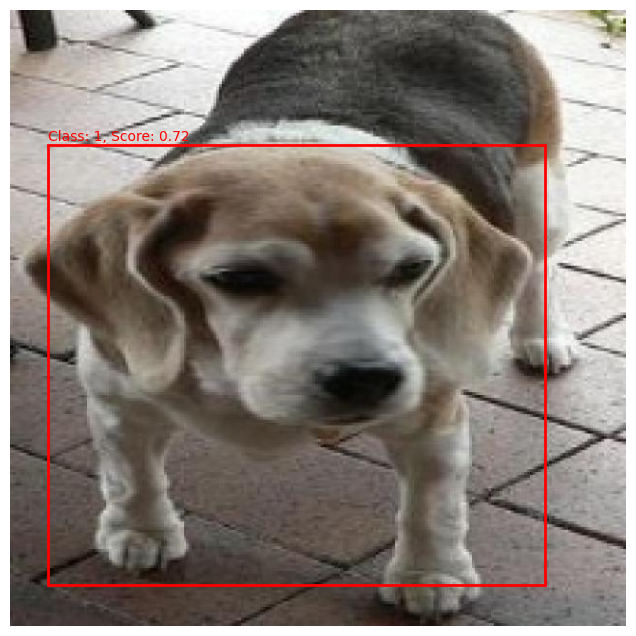

In [ ]:
import matplotlib.pyplot as plt

# ฟังก์ชันวาด bounding box
def draw_boxes(image_path, prediction, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box
            plt.gca().add_patch(plt.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='red', facecolor='none'
            ))
            plt.text(x_min, y_min - 5, f"Class: {label}, Score: {score:.2f}", color='red')

    plt.axis('off')
    plt.show()

# แสดงภาพพร้อม bounding boxes
draw_boxes(image_path, prediction, threshold=0.5)


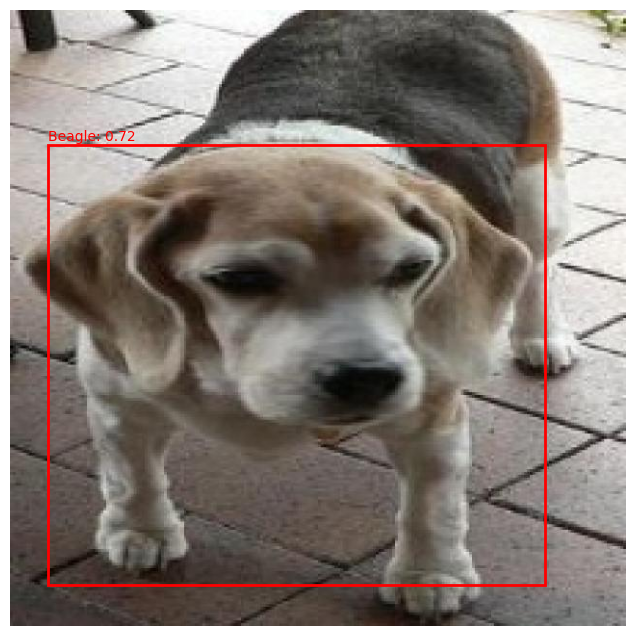

In [ ]:
#
COCO_CLASSES = {0: "Background", 1: "Beagle", 2: "bullDog", 3: "corgi", 4: "goldenRetriever", 5: "husky", 6: "pomeranian"}


def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

def draw_boxes_with_labels(image_path, prediction, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)
            plt.gca().add_patch(plt.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='red', facecolor='none'
            ))
            plt.text(x_min, y_min - 5, f"{class_name}: {score:.2f}", color='red')

    plt.axis('off')
    plt.show()

draw_boxes_with_labels(image_path, prediction, threshold=0.5)


/usr/local/lib/python3.11/dist-packages/torchvision/utils.py:211: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


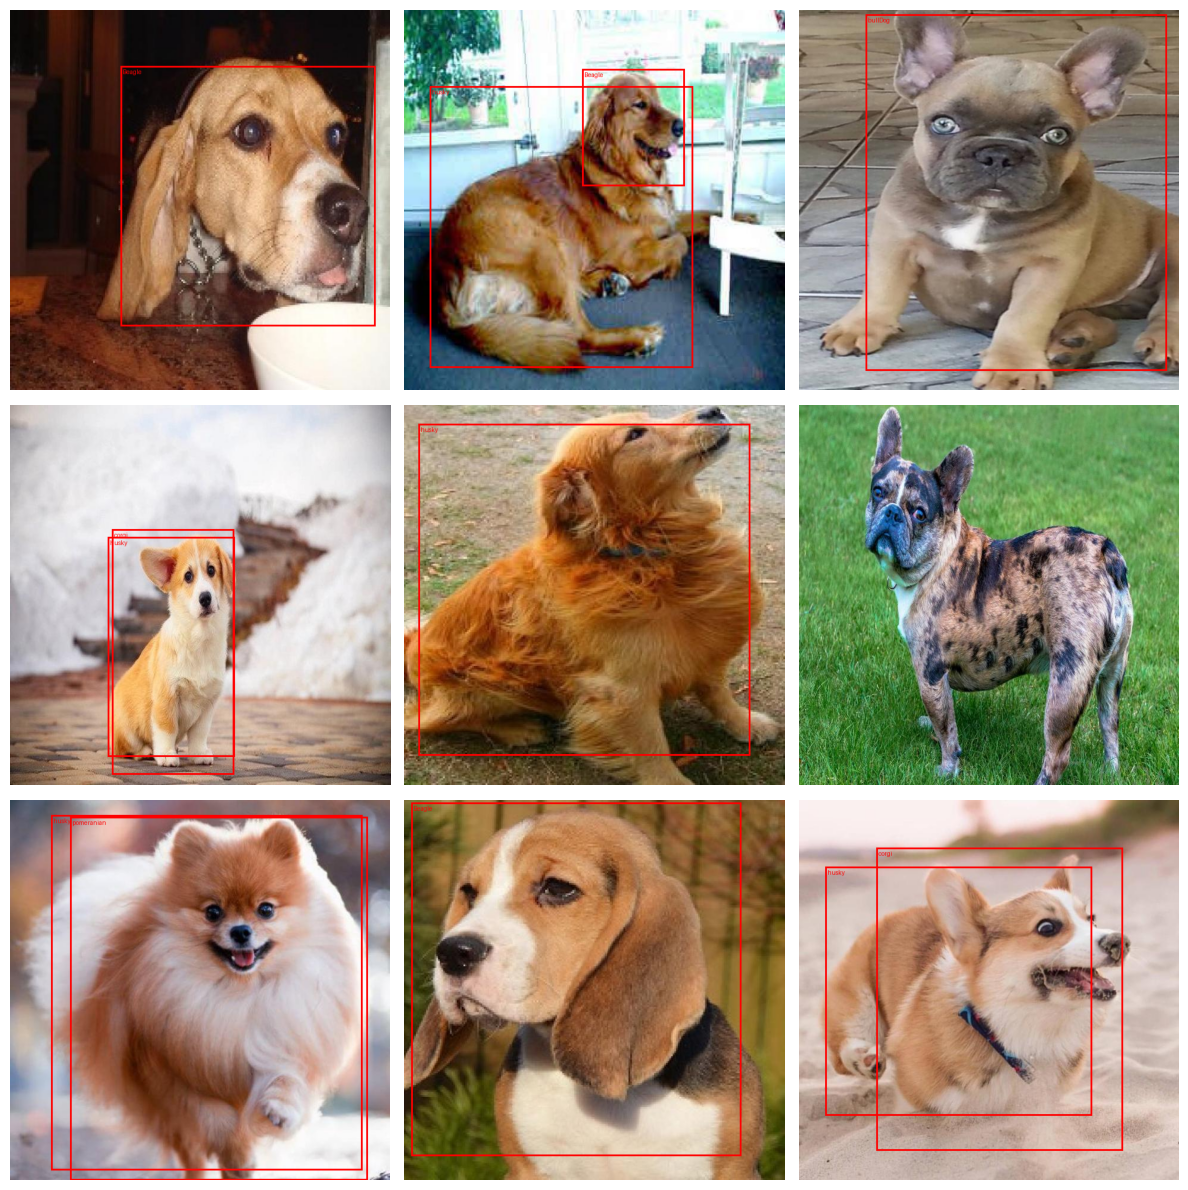

In [ ]:
import os
import random
import torchvision.transforms as T
from torchvision.utils import draw_bounding_boxes


# ฟังก์ชันสำหรับโหลดและแปลงรูปภาพ
def load_image(image_path, device):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.ToTensor(),  # แปลงภาพเป็น Tensor
    ])
    return transform(image).to(device)

# ฟังก์ชันสำหรับสุ่มเลือกไฟล์รูปภาพ
def get_random_images(folder_path, num_images=9):
    all_images = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    return random.sample(all_images, num_images)

# ฟังก์ชันสำหรับแสดงผลการพยากรณ์
def plot_predictions(images, predictions, class_labels, num_images=9):
    rows, cols = 3, 3
    fig, axs = plt.subplots(rows, cols, figsize=(12, 12))

    for idx, ax in enumerate(axs.ravel()):
        img = images[idx]
        pred = predictions[idx]

        # ดึง bounding box และ label จากการพยากรณ์
        boxes = pred["boxes"]
        labels = pred["labels"]
        scores = pred["scores"]

        # กรองผลที่มีความมั่นใจสูงกว่า 0.4
        keep = scores > 0.4
        boxes = boxes[keep]
        labels = labels[keep]
        scores = scores[keep]

        # ใส่กรอบและ label ลงในภาพ
        img_with_boxes = draw_bounding_boxes(
            (img * 255).byte(),  # แปลงกลับเป็น uint8
            boxes=boxes,
            labels=[class_labels[label] for label in labels],
            colors="red",
            width=3
        )

        # แสดงผลภาพ
        ax.imshow(img_with_boxes.permute(1, 2, 0).cpu())
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Path ของโฟลเดอร์ test images และไฟล์ model
test_folder = "/content/Dataset/test"

# Class labels (แก้ไขตาม dataset ของคุณ)
class_labels = ["Background", "Beagle", "bullDog", "corgi", "goldenRetriever", "husky", "pomeranian"]

# ดึงภาพสุ่มจากโฟลเดอร์
random_images = get_random_images(test_folder, num_images=9)

# เตรียมภาพสำหรับ predict
images = [load_image(img_path, device) for img_path in random_images]

# ทำการพยากรณ์
with torch.no_grad():
    predictions = model(images)

# แสดงผล
plot_predictions(images, predictions, class_labels)
